**PREDIÇÃO DA VIDA ÚTIL DE MOTORES AERONÁUTICOS (RUL)**

**Este projeto tem como objetivo desenvolver uma solução preditiva de alto nível para estimar a vida útil remanescente (RUL) de motores aeronáuticos, utilizando dados reais de sensores operacionais, ciclos de operação e variáveis derivadas com alto valor informativo. Por meio de um modelo híbrido inteligente, que combina redes neurais recorrentes (LSTM) com algoritmos baseados em árvore (XGBoost), o sistema é capaz de prever com elevada precisão quantos ciclos restam até a falha de cada motor.**

**A abordagem adotada permite capturar tanto padrões temporais complexos de degradação quanto relações diretas com variáveis críticas, oferecendo predições robustas e interpretáveis. A solução inclui também a classificação do risco operacional (Normal, Alerta, Manutenção), além de um indicador visual de erro para cada previsão, facilitando a análise e a tomada de decisão.**

**Sobre o Dataset:**

**Um motor (id) é monitorado em vários momentos da sua vida útil (ciclos).**

**Cada cycle é um ponto no tempo (tipo um "frame" da operação). Em cada ciclo, temos: 3 parâmetros operacionais (setting1, setting2, setting3) e 21 leituras de sensores físicos (s1 a s21).**



In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [2]:
# Carregando a base de dados
df = pd.read_excel('/content/PM_train.xlsx')

In [3]:
# Observando
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


In [4]:
df.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
20626,100,196,-0.0004,-0.0003,100,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100,38.30,23.1594
20628,100,198,0.0004,0.0000,100,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100,38.44,22.9333
20629,100,199,-0.0011,0.0003,100,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100,38.29,23.0640
20630,100,200,-0.0032,-0.0005,100,518.67,643.85,1600.38,1432.14,14.62,...,519.30,2388.26,8137.33,8.5036,0.03,396,2388,100,38.37,23.0522


In [5]:
df.shape

(20631, 26)

In [6]:
# Informações sobre os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  int64  
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

In [7]:
# Dados estatísticos
df.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [8]:
# Verificando a existência de valores nulos
df.isnull().sum()

,0
id,0
cycle,0
setting1,0
setting2,0
setting3,0
s1,0
s2,0
s3,0
s4,0
s5,0


In [9]:
# Quantos motores únicos no dataset
num_motores = df['id'].nunique()
print(f"🔧 O dataset possui {num_motores} motores diferentes.")



🔧 O dataset possui 100 motores diferentes.


In [10]:
# Contar quantos ciclos cada motor possui
ciclos_por_motor = df.groupby("id")["cycle"].nunique().reset_index()
ciclos_por_motor.columns = ["Motor_ID", "Qtd_Ciclos"]

print(ciclos_por_motor)



    Motor_ID  Qtd_Ciclos
0          1         192
1          2         287
2          3         179
3          4         189
4          5         269
..       ...         ...
95        96         336
96        97         202
97        98         156
98        99         185
99       100         200

[100 rows x 2 columns]


In [11]:
# Estatísticas gerais
print(ciclos_por_motor["Qtd_Ciclos"].describe())

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: Qtd_Ciclos, dtype: float64


**Percebemos acima que a maioria dos motores possui uma vida útil entre 177 e 229 ciclos, concentrando-se em torno de ~200 ciclos até a falha. No entanto, há variação considerável entre unidades, com alguns motores apresentando desgaste precoce (falha antes de 130 ciclos) e outros alcançando longevidades mais altas (até 362 ciclos).**

In [12]:
# Coeficiente de variação: std / mean (ignora médias muito próximas de zero)
cv = df.std() / df.mean()

# Filtrar colunas com CV < 0.01 (baixa variabilidade relativa)
low_variability_cols = cv[cv < 0.01].index.tolist()

# Mostrar colunas
print("Colunas com baixa variabilidade (CV < 1%):")
for col in low_variability_cols:
    print(f"{col}: CV = {cv[col]:.5f}")

Colunas com baixa variabilidade (CV < 1%):
setting1: CV = -246.59270
setting3: CV = 0.00000
s1: CV = 0.00000
s2: CV = 0.00078
s3: CV = 0.00385
s4: CV = 0.00639
s5: CV = 0.00000
s6: CV = 0.00006
s7: CV = 0.00160
s8: CV = 0.00003
s9: CV = 0.00244
s10: CV = 0.00000
s11: CV = 0.00562
s12: CV = 0.00141
s13: CV = 0.00003
s14: CV = 0.00234
s15: CV = 0.00444
s16: CV = 0.00000
s17: CV = 0.00394
s18: CV = 0.00000
s19: CV = 0.00000
s20: CV = 0.00466
s21: CV = 0.00465


In [13]:
# Dropando as colunas com variabilidade 0
df.drop(columns=['setting3', 's1', 's5', 's6', 's10', 's13', 's16', 's18', 's19'], inplace=True)

Text(0.5, 1.0, 'Distribuição do ciclo final por motor')

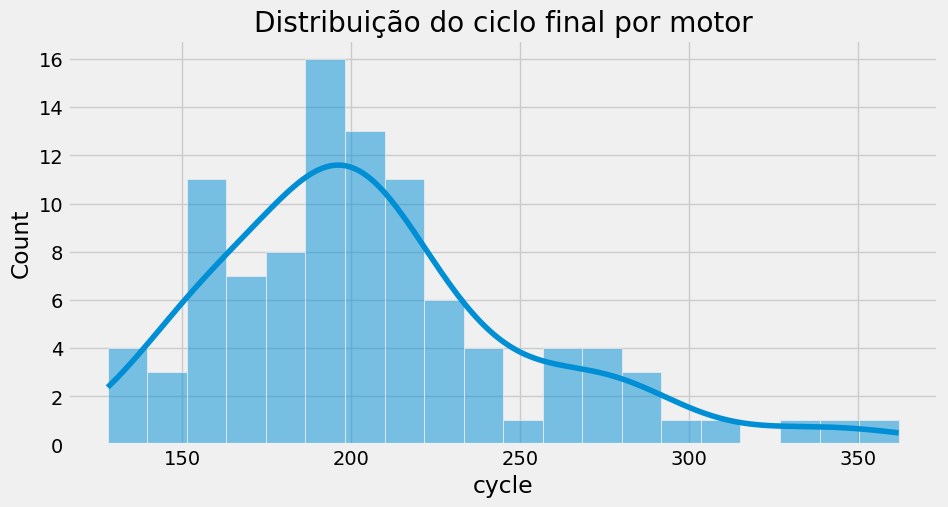

In [14]:
sns.histplot(df.groupby('id')['cycle'].max(), bins=20, kde=True)
plt.title("Distribuição do ciclo final por motor")

**O gráfico acima nos diz: Cada barra representa quantos motores chegaram até um determinado número de ciclos antes de falharem. A curva de densidade (linha azul) mostra a tendência geral de vida útil dos motores. Notamos que a maioria dos motores falham entre 180 e 220 ciclos e poucos passam dos 300 ciclos.**

**Agora vamos cria a variável alvo RUL (Remaining Useful Life), que nada mais é do que o ciclo de vida restante que um motor tem antes de falhar.**

In [15]:
# Calcular o ciclo máximo (ciclo de falha) por motor
rul_por_motor = df.groupby('id')['cycle'].max().reset_index()
rul_por_motor.columns = ['id', 'max_cycle']

In [16]:
# Juntar essa info ao dataframe original
df = df.merge(rul_por_motor, on='id', how='left')

In [17]:
# Calcular o RUL: diferença entre ciclo final e ciclo atual
df['RUL'] = df['max_cycle'] - df['cycle']

In [18]:
# Remover a coluna auxiliar 'max_cycle' se quiser
df.drop(columns='max_cycle', inplace=True)

In [19]:
# Visualizando as primeiras linhas com a nova coluna
df[['id', 'cycle', 'RUL']].head()

,id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


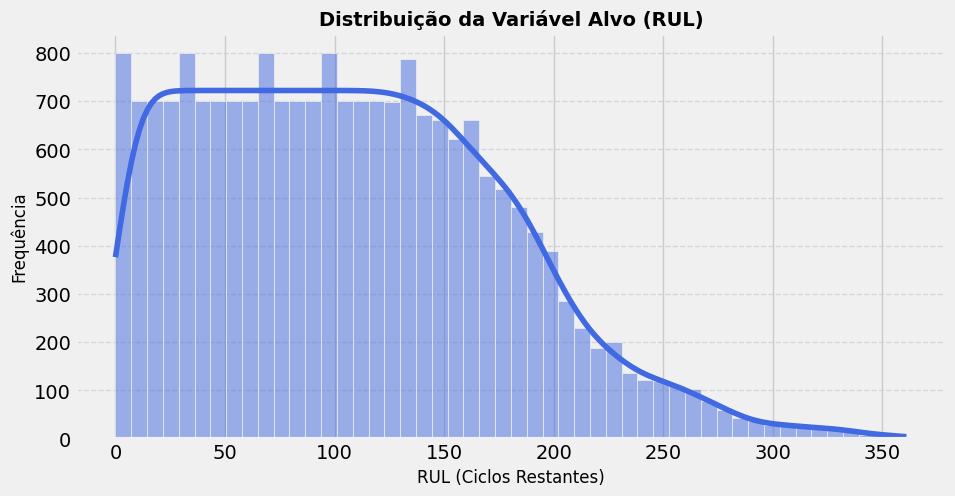

In [20]:
# Observando a distribuição da variável alvo
plt.figure(figsize=(10,5))
sns.histplot(df["RUL"], bins=50, kde=True, color="royalblue")

plt.title("Distribuição da Variável Alvo (RUL)", fontsize=14, fontweight="bold")
plt.xlabel("RUL (Ciclos Restantes)", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


**O histograma acima apresenta a distribuição da Remaining Useful Life (RUL) ao longo de todos os motores e ciclos, observamos que existe uma alta concentração de valores baixos de RUL próximos a zero, o que é esperado, pois todos os motores finalizam seu ciclo de vida em RUL = 0. A frequência de observações se mantém relativamente estável até cerca de 150 ciclos restantes, refletindo o fato de que os motores são monitorados de forma contínua durante sua degradação, a partir desse ponto, a frequência começa a decrescer gradualmente, com poucos motores alcançando valores de RUL superiores a 250 ciclos. Esse comportamento gera uma distribuição assimétrica à direita, típica em problemas de manutenção preditiva, onde os dados são mais abundantes próximos da falha e escassos em horizontes de prognóstico mais longos.**

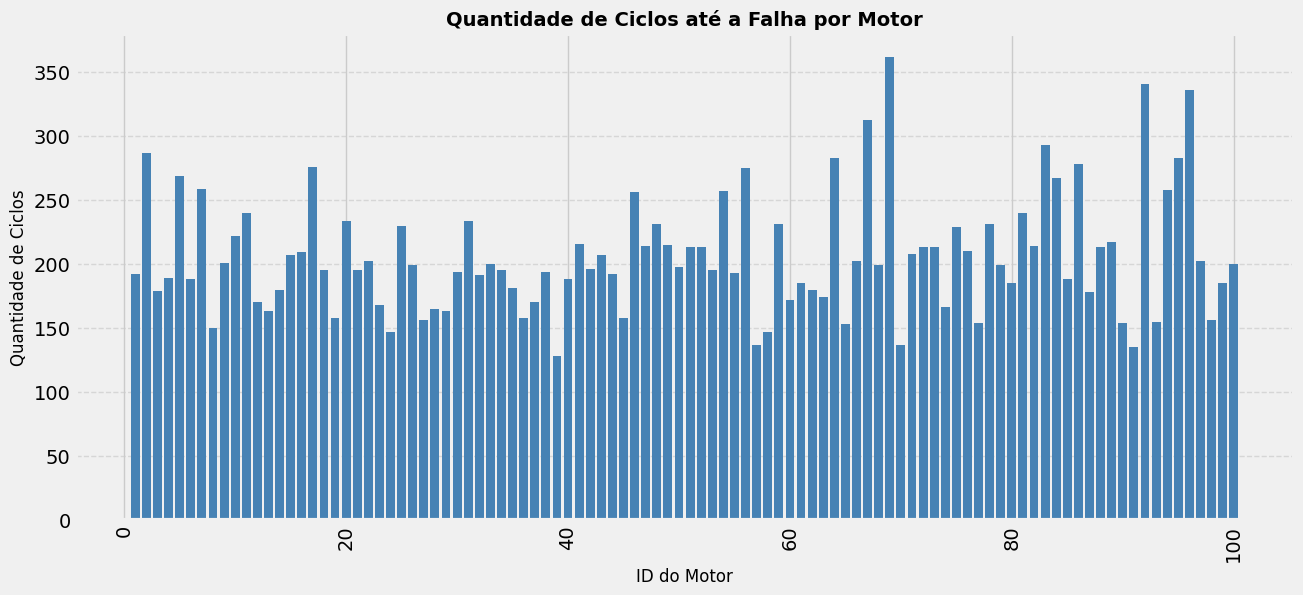

In [21]:
# Agrupar ciclos por motor
ciclos_por_motor = df.groupby("id")["cycle"].nunique().reset_index()
ciclos_por_motor.columns = ["Motor_ID", "Qtd_Ciclos"]

# Plotar gráfico de barras
plt.figure(figsize=(14,6))
plt.bar(ciclos_por_motor["Motor_ID"], ciclos_por_motor["Qtd_Ciclos"], color="steelblue")

plt.title("Quantidade de Ciclos até a Falha por Motor", fontsize=14, fontweight="bold")
plt.xlabel("ID do Motor", fontsize=12)
plt.ylabel("Quantidade de Ciclos", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


**O gráfico acima apresenta o número de ciclos realizados por cada motor antes de atingir a falha. Percebemos que só confirma o que vimos anteriormente sobre a variabilidade na vida útil dos motores. Existem motores que superam a média, prolongando a vida útil, da mesma forma existem motores que falharam de forma precoce, indicando possíveis diferença em condições operacionais, desgaste acelerado ou variabilidade de fabricação.**

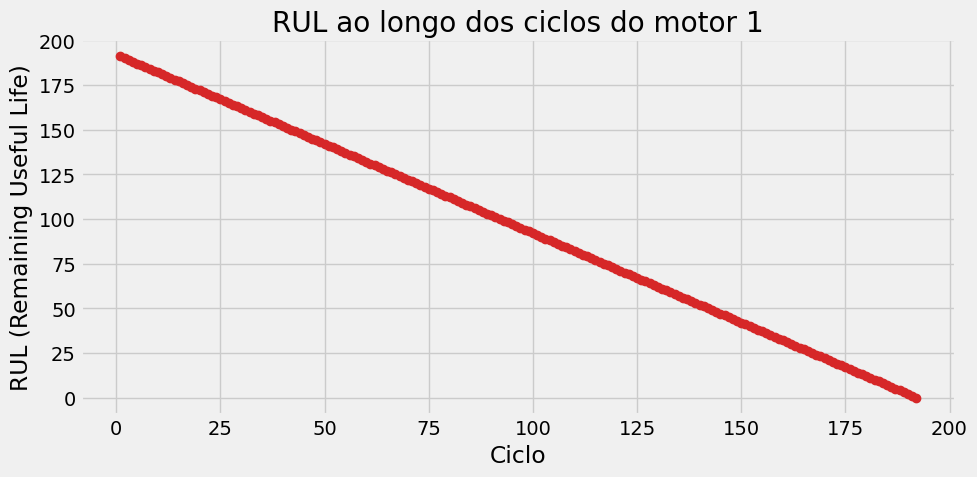

In [22]:
# Escolhendo um motor de exemplo
motor_id = 1

# Filtrar os dados desse motor
df_motor = df[df['id'] == motor_id]

# Plotar a linha de RUL ao longo do tempo
plt.figure(figsize=(10, 5))
plt.plot(df_motor['cycle'], df_motor['RUL'], marker='o', color='tab:red')
plt.title(f"RUL ao longo dos ciclos do motor {motor_id}")
plt.xlabel("Ciclo")
plt.ylabel("RUL (Remaining Useful Life)")
plt.grid(True)
plt.tight_layout()
plt.show()

**O gráfico acima nos mostra claramente uma queda linear ao longo dos ciclos.**

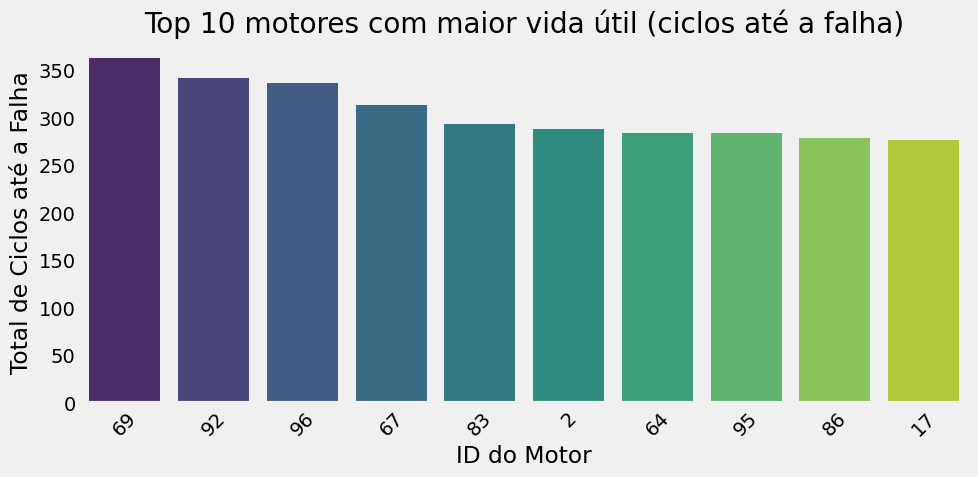

In [23]:
# Calcular o ciclo final (máximo) de cada motor
ciclos_finais = df.groupby('id')['cycle'].max()

# Selecionando os 10 motores com maior vida útil
top10_motores = ciclos_finais.sort_values(ascending=False).head(10)

# Ordenar os dados explicitamente do maior para o menor
top10_motores = top10_motores.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=top10_motores.index.astype(str), y=top10_motores.values, palette='viridis')

plt.title("Top 10 motores com maior vida útil (ciclos até a falha)")
plt.xlabel("ID do Motor")
plt.ylabel("Total de Ciclos até a Falha")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


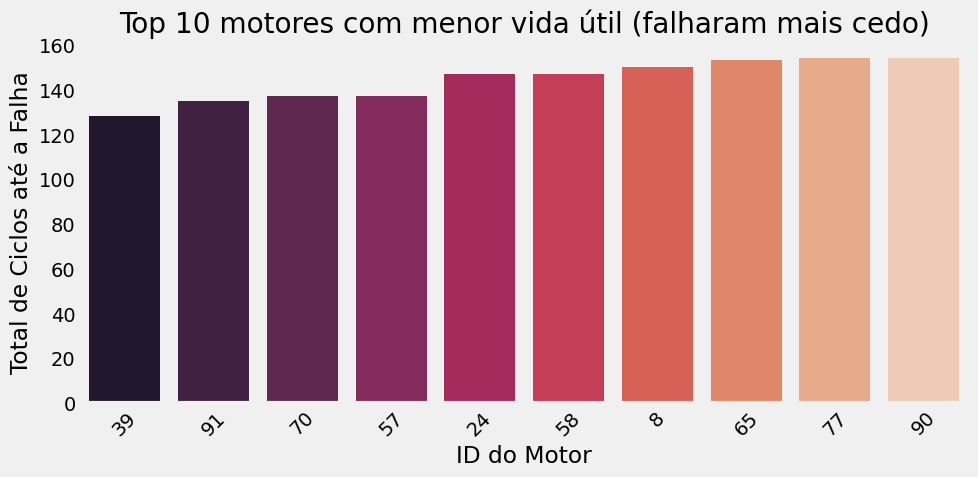

In [24]:
# Calculando o ciclo final (máximo) de cada motor
ciclos_finais = df.groupby('id')['cycle'].max()

# Selecionando os 10 motores com menor vida útil
bottom10_motores = ciclos_finais.sort_values(ascending=True).head(10)

# Ordenar explicitamente em ordem crescente para garantir visualização correta
bottom10_motores = bottom10_motores.sort_values(ascending=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=bottom10_motores.index.astype(str), y=bottom10_motores.values, palette='rocket')

plt.title("Top 10 motores com menor vida útil (falharam mais cedo)")
plt.xlabel("ID do Motor")
plt.ylabel("Total de Ciclos até a Falha")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

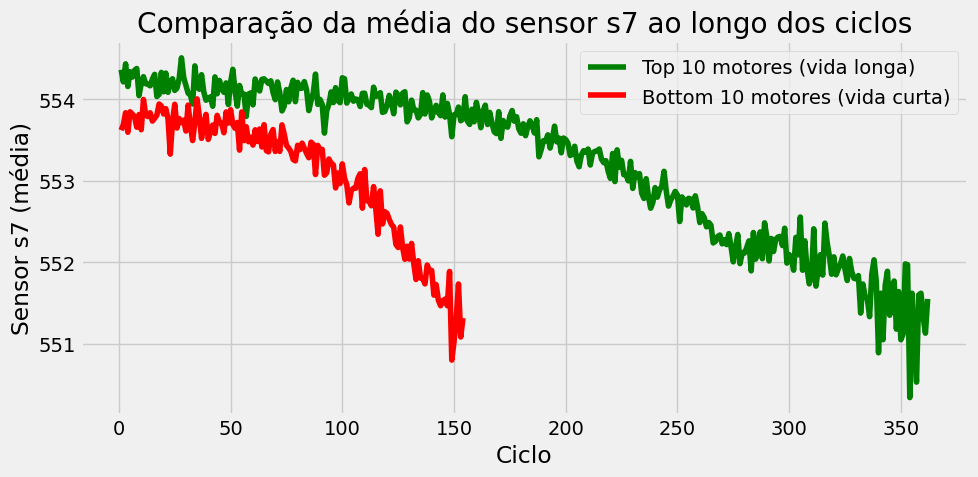

In [25]:
# Definindo top e bottom motores
top_ids = ciclos_finais.sort_values(ascending=False).head(10).index.tolist()
bottom_ids = ciclos_finais.sort_values().head(10).index.tolist()

# Filtrar dados
df_top = df[df['id'].isin(top_ids)]
df_bottom = df[df['id'].isin(bottom_ids)]

# Agrupando por ciclo e tirando média do sensor (ex: s7)
top_media_s7 = df_top.groupby('cycle')['s7'].mean()
bottom_media_s7 = df_bottom.groupby('cycle')['s7'].mean()

plt.figure(figsize=(10, 5))
plt.plot(top_media_s7, label='Top 10 motores (vida longa)', color='green')
plt.plot(bottom_media_s7, label='Bottom 10 motores (vida curta)', color='red')
plt.title("Comparação da média do sensor s7 ao longo dos ciclos")
plt.xlabel("Ciclo")
plt.ylabel("Sensor s7 (média)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Acima percebemos que os valores do sensor caem mais cedo devido ao motor com ciclo de vida menor.**

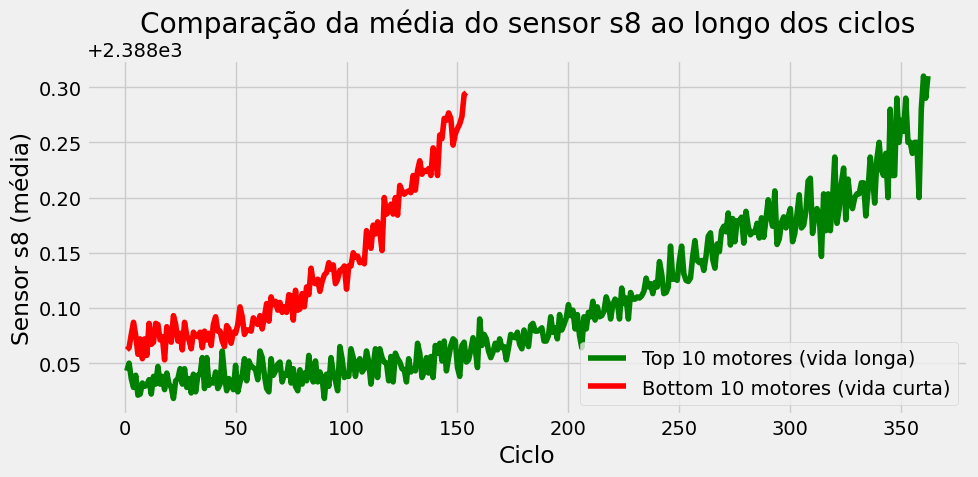

In [26]:
# Definindo top e bottom motores
top_ids = ciclos_finais.sort_values(ascending=False).head(10).index.tolist()
bottom_ids = ciclos_finais.sort_values().head(10).index.tolist()

# Filtrar dados
df_top = df[df['id'].isin(top_ids)]
df_bottom = df[df['id'].isin(bottom_ids)]

# Agrupando por ciclo e tirando média do sensor (ex: s8)
top_media_s8 = df_top.groupby('cycle')['s8'].mean()
bottom_media_s8 = df_bottom.groupby('cycle')['s8'].mean()

plt.figure(figsize=(10, 5))
plt.plot(top_media_s8, label='Top 10 motores (vida longa)', color='green')
plt.plot(bottom_media_s8, label='Bottom 10 motores (vida curta)', color='red')
plt.title("Comparação da média do sensor s8 ao longo dos ciclos")
plt.xlabel("Ciclo")
plt.ylabel("Sensor s8 (média)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Acima percebemos que os motores duráveis operam com s8 baixo por bastante tempo, o que mostra eficiência estável, sem sobrecarga de fluxo. Já os motores fracos apresentam aumento precoce e acelerado no s8, indicando estresse operacional ou vazão anormal precoce. provavelmente é um sensor que representa a taxa de fluxo de combustível.**

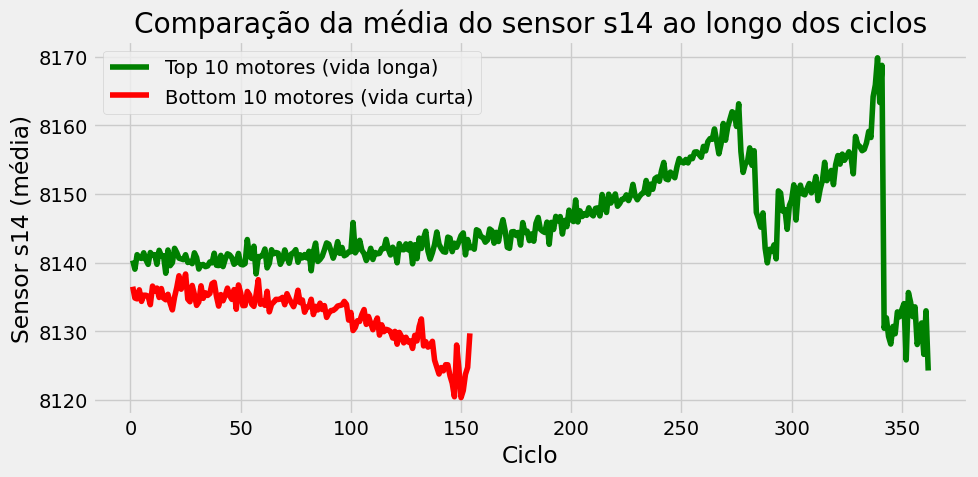

In [27]:
# Definindo top e bottom motores
top_ids = ciclos_finais.sort_values(ascending=False).head(10).index.tolist()
bottom_ids = ciclos_finais.sort_values().head(10).index.tolist()

# Filtrar dados
df_top = df[df['id'].isin(top_ids)]
df_bottom = df[df['id'].isin(bottom_ids)]

# Agrupando por ciclo e tirando média do sensor (ex: s14)
top_media_s14 = df_top.groupby('cycle')['s14'].mean()
bottom_media_s14 = df_bottom.groupby('cycle')['s14'].mean()

plt.figure(figsize=(10, 5))
plt.plot(top_media_s14, label='Top 10 motores (vida longa)', color='green')
plt.plot(bottom_media_s14, label='Bottom 10 motores (vida curta)', color='red')
plt.title("Comparação da média do sensor s14 ao longo dos ciclos")
plt.xlabel("Ciclo")
plt.ylabel("Sensor s14 (média)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Percebemos acima que os motores com maior vida útil começam estáveis (8140), mantem esse nível até aproximadamente o ciclo 200, em seguida apresentam uma curva ascendente gradual e notamos oscilações acentuadas após ciclo 300. Isso pode reprsentar aumento de vibração ou expansão térmica estrutural natural do desgaste, mas de forma lenta e controlada. Os motores que duram menos á começam com valores mais baixos (8135) e apresentam uma queda consistente perto do fim da vida.**

**Agora vamos criar a feature 'cycle_norm' que vai representar o ciclo atual do motor normalizado em relação ao seu ciclo final de vida. Como cada motor no dataset possui uma quantidade diferente de ciclos até a falha, normalizar o tempo de operação para uma escala de 0 a 1 permite ao modelo entender em que estágio da vida útil o motor está, independentemente da sua duração total. Quando 'cycle_norm' = 0, o motor está no início da operação. Quando 'cycle_norm' = 1, o motor está prestes a falhar. Essa normalização torna o modelo mais robusto e generalizável, pois permite identificar padrões de degradação com base no progresso do tempo, e não em valores absolutos de ciclo, que variam de motor para motor.**

In [28]:
# Criando a feature de ciclo normalizado (0 a 1 para cada motor)
df['cycle_norm'] = df['cycle'] / df.groupby('id')['cycle'].transform('max')

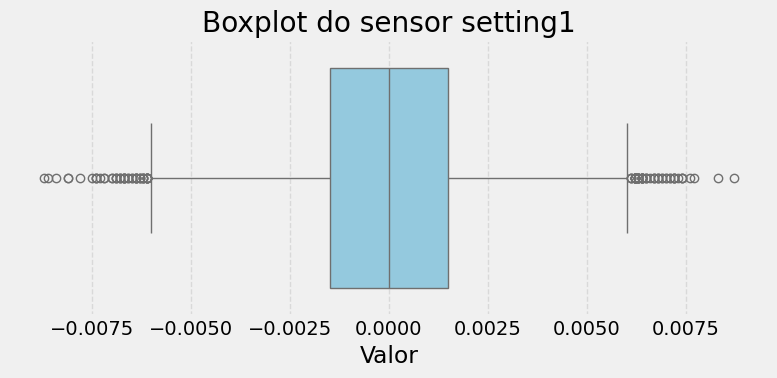

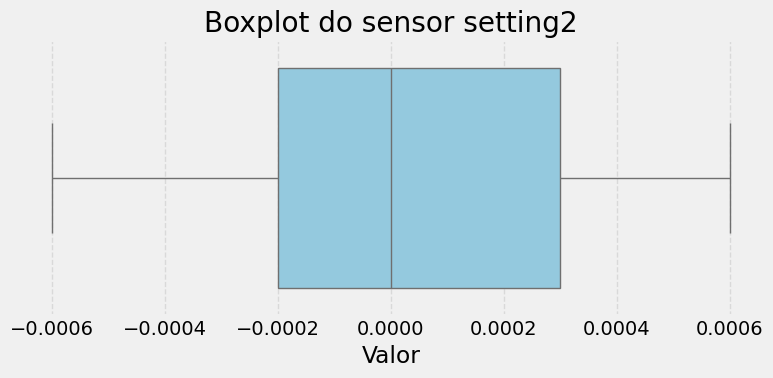

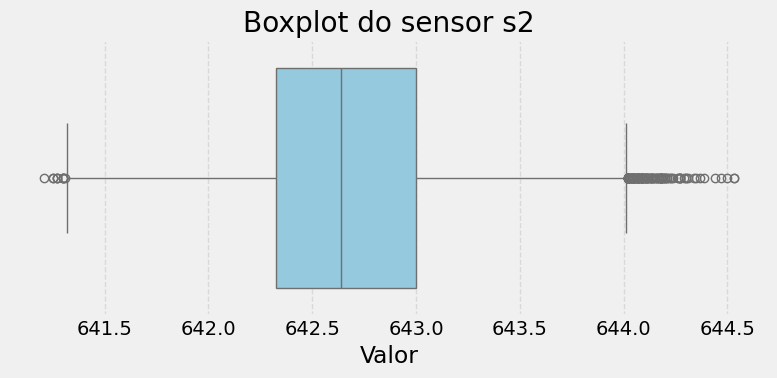

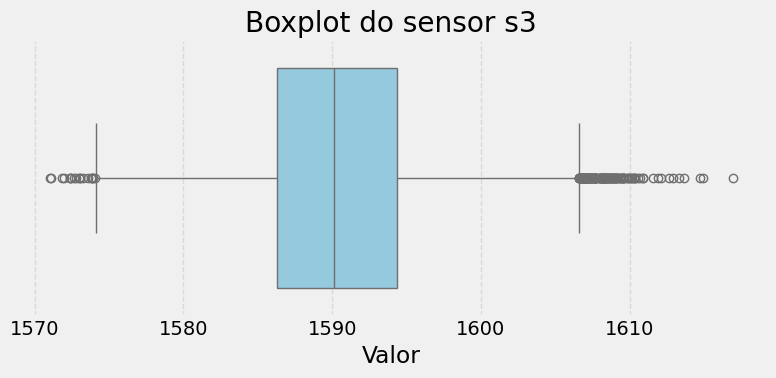

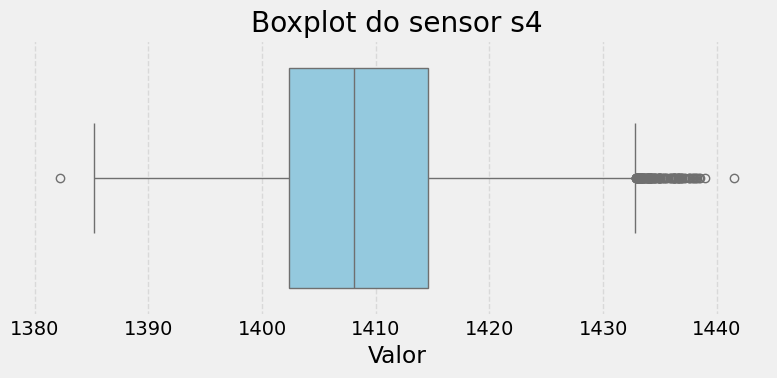

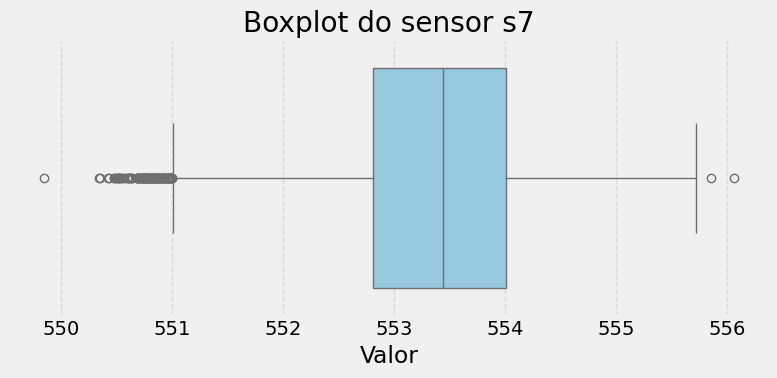

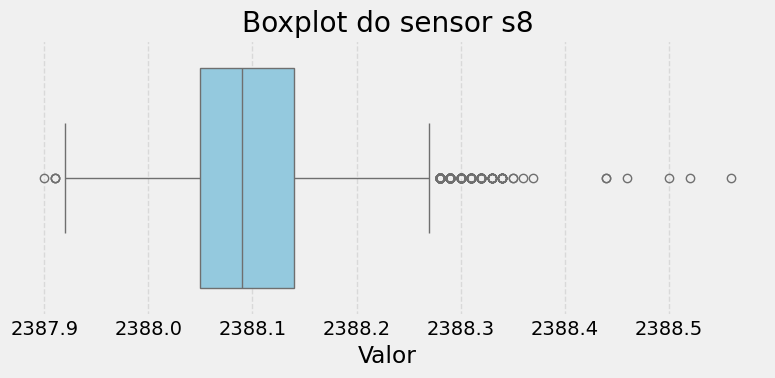

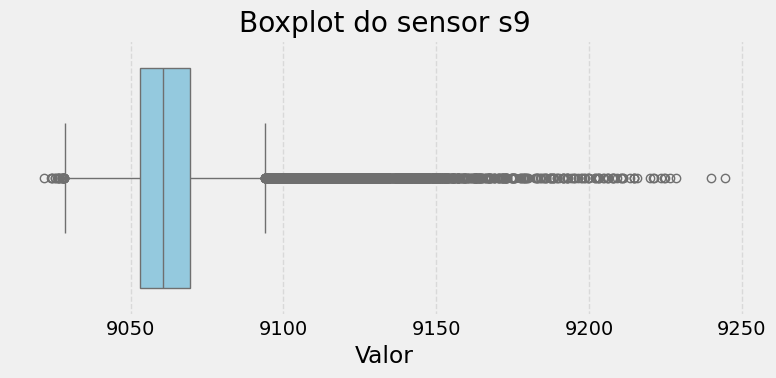

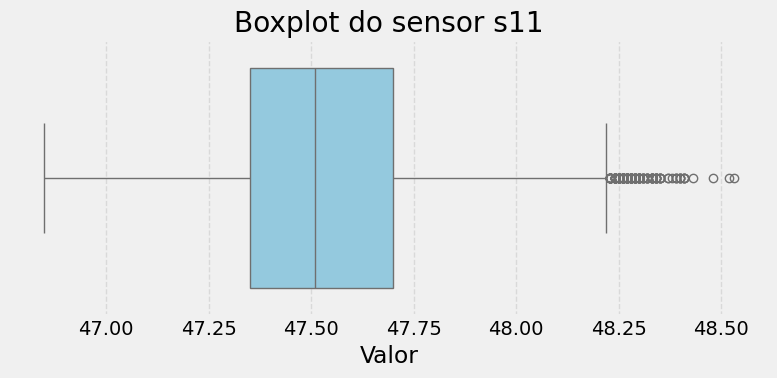

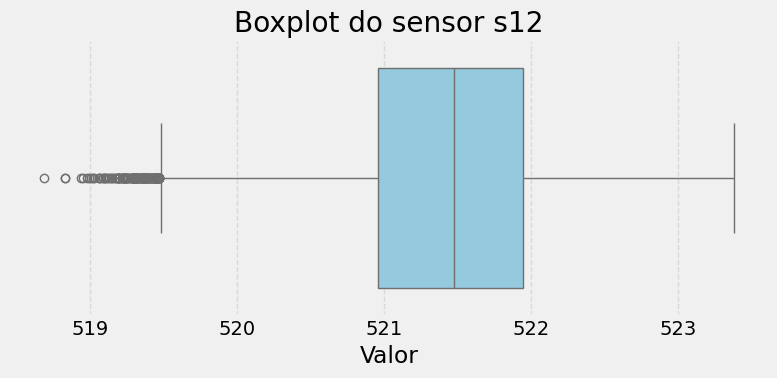

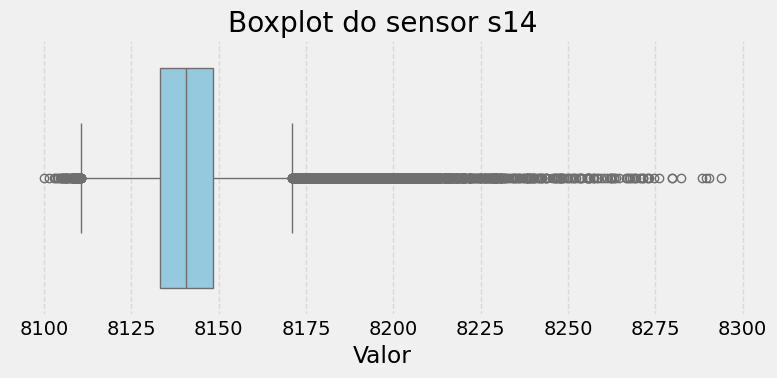

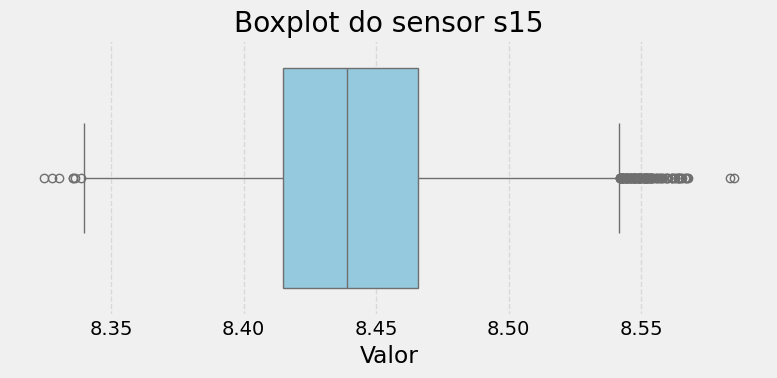

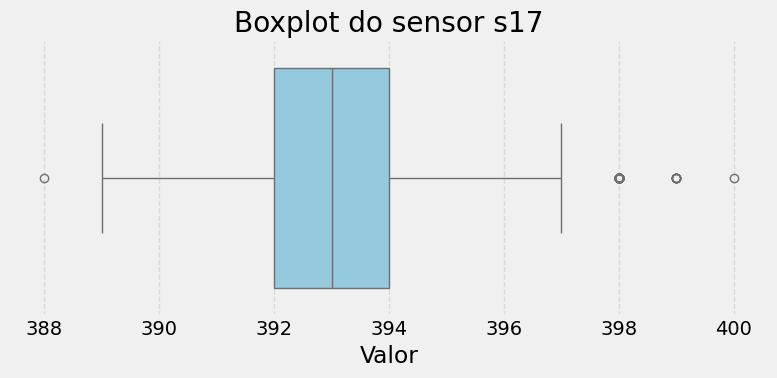

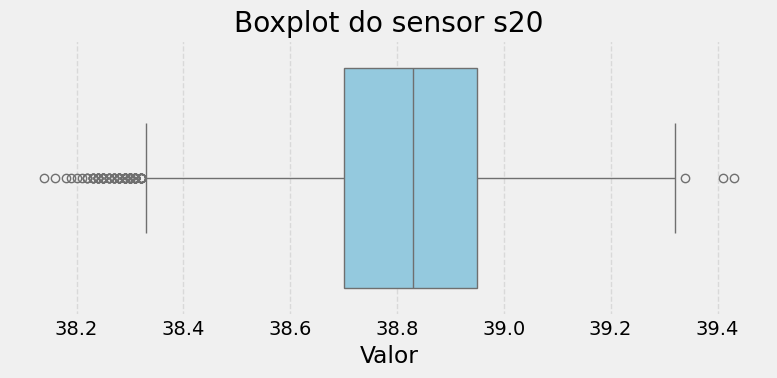

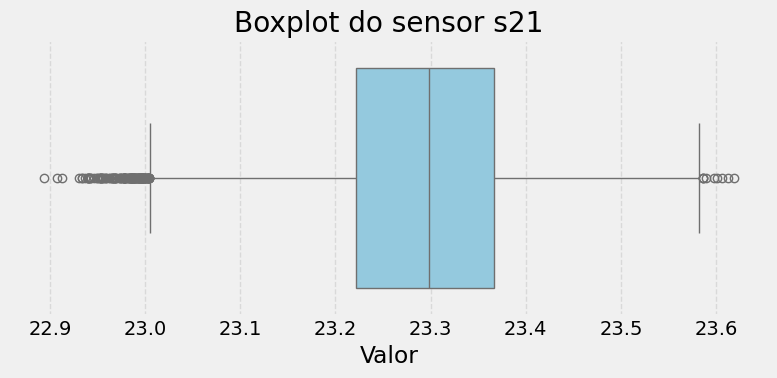

In [29]:
# Lista de colunas de sensores
sensores = [col for col in df.columns if col.startswith('s')]

# Loop para criar boxplot de cada sensor
for sensor in sensores:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[sensor], color='skyblue')
    plt.title(f"Boxplot do sensor {sensor}")
    plt.xlabel("Valor")
    plt.grid(True, axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [30]:
def resumo_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    count_outliers = ((df[col] < lim_inf) | (df[col] > lim_sup)).sum()
    return col, count_outliers

# Aplicando em todos os sensores
sensores = [col for col in df.columns if col.startswith('s')]
resumo = [resumo_outliers(df, col) for col in sensores]
resumo = sorted(resumo, key=lambda x: x[1], reverse=True)
for col, n in resumo:
    print(f"{col}: {n} outliers")

s9: 1686 outliers
s14: 1543 outliers
s8: 320 outliers
s11: 167 outliers
s3: 165 outliers
s12: 146 outliers
s21: 136 outliers
s2: 128 outliers
s4: 120 outliers
s15: 120 outliers
s20: 117 outliers
s7: 110 outliers
setting1: 105 outliers
s17: 81 outliers
setting2: 0 outliers


**Percebemos nas informações acima que existem muito outliers, mas todos são dados reais e importantes, pois a medida que os ciclos vão acabando, as falhas aumentam como maior consumo, mais vibrações,, temperatura e pressão fora do padrão, etc.**

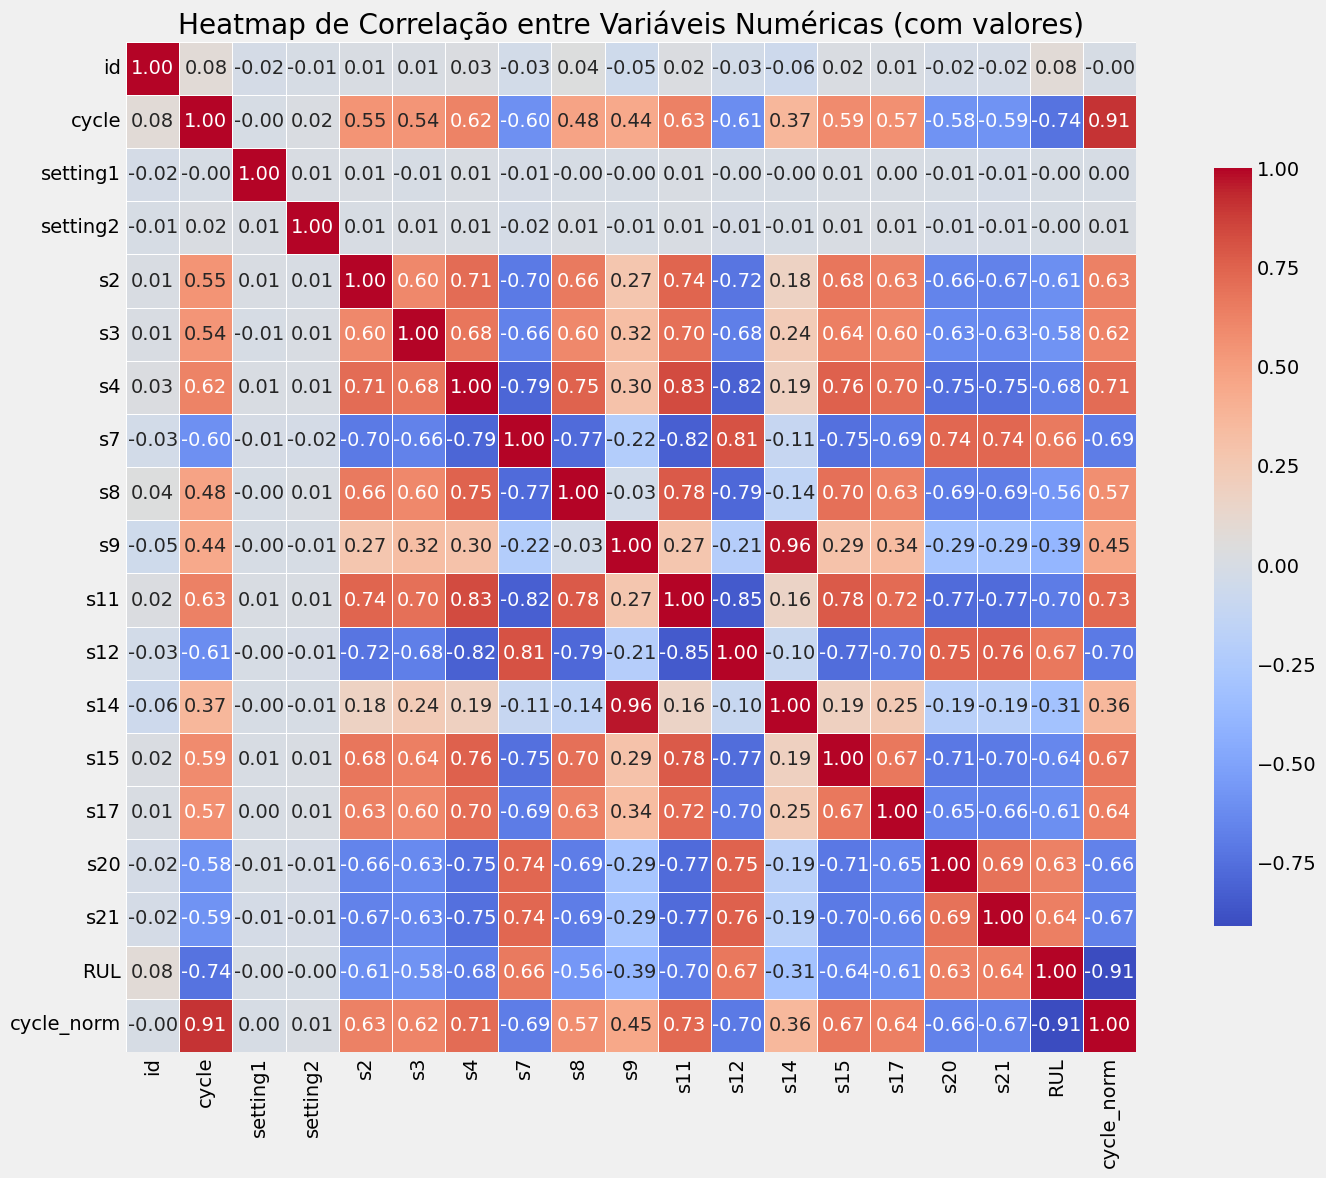

In [31]:
# Selecionando apenas colunas numéricas (sensores, settings, RUL)
numeric_cols = df.select_dtypes(include='number')

# Calculando a matriz de correlação
correlacao = numeric_cols.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    correlacao,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.75}
)
plt.title("Heatmap de Correlação entre Variáveis Numéricas (com valores)")
plt.tight_layout()
plt.show()


In [32]:
# Cópia base e ordenação
df_base = df.copy()
df_base['id'] = df_base['id'].astype(int)
df_base = df_base.sort_values(['id', 'cycle_norm'])

# Seleção de sensores úteis (NASA FD001)
useful_sensors = ['cycle','s2','s3','s4','s7','s11','s12','s15','s17','s20','s21']

**Agora vamos criar delta features, que são variáveis que capturam a variação ciclo a ciclo dos sensores para cada motor individualmente. Em vez de considerar apenas os valores absolutos dos sensores, o modelo também aprende como esses valores estão mudando ao longo do tempo, o que é fundamental para detectar padrões de degradação. Essa abordagem permite capturar sinais sutis de falha, tendências críticas e aceleração da deterioração, fornecendo ao modelo uma visão mais rica da dinâmica do sistema. No contexto de RUL, essa informação é especialmente valiosa, pois a taxa de mudança de um sensor pode ser um indicativo mais forte de falha iminente do que seu valor isolado. Ao incluir tanto os valores originais quanto suas diferenças (deltas), aumentamos o poder preditivo do modelo sem inflar excessivamente a dimensionalidade.**

In [33]:
# Delta features
for col in useful_sensors:
    df_base[f'{col}_delta'] = df_base.groupby('id')[col].diff().fillna(0)

# Lista final de features
features = useful_sensors + [f'{col}_delta' for col in useful_sensors]

In [34]:
# Separação dos motores
motores = df_base['id'].unique()
np.random.seed(42)
np.random.shuffle(motores)
train_ids = motores[:70]
val_ids   = motores[70:85]
test_ids  = motores[85:]

train_df = df_base[df_base['id'].isin(train_ids)]
val_df   = df_base[df_base['id'].isin(val_ids)]
test_df  = df_base[df_base['id'].isin(test_ids)]

# Filtragem a partir do ciclo 125 (degradação real)
train_deg = train_df[train_df['cycle'] >= 125].copy()
val_deg   = val_df[val_df['cycle'] >= 125].copy()
test_deg  = test_df[test_df['cycle'] >= 125].copy()

# Escalonamento
scaler = StandardScaler()
train_deg[features] = scaler.fit_transform(train_deg[features])
val_deg[features]   = scaler.transform(val_deg[features])
test_deg[features]  = scaler.transform(test_deg[features])

**Como estamos lidando com um problema de séries temporais multivariadas, precisamos estruturar os dados no formato adequado para modelos sequenciais como LSTM. Para isso, vamos criar a função create_sequences(), que organiza os dados de cada motor em janelas deslizantes de comprimento fixo (SEQ_LEN = 30). Ou seja, para cada ciclo, o modelo recebe como entrada os últimos 30 ciclos anteriores de sensores e aprende a prever a vida útil restante (RUL) correspondente ao ciclo atual. Esse formato permite ao modelo capturar padrões temporais, tendências e variações nos sensores ao longo do tempo, que são fundamentais para prever corretamente a degradação do motor.**

In [35]:
SEQ_LEN = 30

def create_sequences(df, features, target_col='RUL'):
    X_seq, y_seq = [], []
    for _, g in df.groupby('id'):
        Xg = g[features].values
        yg = g[target_col].values
        for i in range(SEQ_LEN, len(g)):
            X_seq.append(Xg[i-SEQ_LEN:i])
            y_seq.append(yg[i])
    return np.array(X_seq), np.array(y_seq)

# Aplicação da função para treino, validação e teste
X_train_seq, y_train_seq = create_sequences(train_deg, features)
X_val_seq,   y_val_seq   = create_sequences(val_deg, features)
X_test_seq,  y_test_seq  = create_sequences(test_deg, features)

print("Shapes — X_train_seq:", X_train_seq.shape, "| y_train_seq:", y_train_seq.shape)


Shapes — X_train_seq: (3620, 30, 22) | y_train_seq: (3620,)


**Como o modelo LSTM recebe uma sequência completa como entrada, ele considera o histórico temporal de vários ciclos. No entanto, modelos como o XGBoost, que são baseados em aprendizado tabular, exigem entradas vetoriais fixas e independentes. Por isso, extraímos o último time step de cada sequência (ou seja, o ciclo mais recente da janela de 30 ciclos) usando X[:, -1, :]. Essa abordagem permite ao XGBoost aprender com o estado atual do motor, baseado apenas nas variáveis do ciclo mais recente, enquanto o LSTM aprende a partir do histórico. Essa extração é essencial para permitir a combinação dos dois modelos em uma arquitetura híbrida, onde cada um contribui com sua especialidade.**

In [36]:
# Separando o último passo de cada sequência para o XGBoost e para o meta-modelo
X_train_last = X_train_seq[:, -1, :]
X_val_last   = X_val_seq[:, -1, :]
X_test_last  = X_test_seq[:, -1, :]

***Foi optado por uma arquitetura híbrida para aproveitar o melhor de dois mundos: a capacidade do LSTM de capturar padrões temporais e sequenciais de degradação ao longo dos ciclos, e a robustez do XGBoost em lidar com variáveis tabulares e detectar variações abruptas em sensores no ciclo atual. O LSTM é alimentado com janelas deslizantes de 30 ciclos e aprende a modelar a tendência de degradação ao longo do tempo, enquanto o XGBoost recebe apenas o último ciclo da sequência (estado mais recente) e atua como um especialista em prever picos ou mudanças rápidas. Para combinar as previsões dos dois modelos, implementamos uma técnica de blending com ajuste de peso (α*), otimizado com base no conjunto de validação usando um MAE ponderado que dá 3x mais peso aos casos críticos com RUL ≤ 40. Essa estratégia foca o aprendizado onde ele é mais importante: antecipar falhas iminentes com segurança, mesmo que isso custe um pouco de erro nas fases iniciais da vida útil. O resultado é um modelo altamente confiável, preciso nas zonas críticas, e adaptado à realidade operacional da manutenção preditiva.***

In [37]:
# Criando o modelo LSTM

input_shape = (SEQ_LEN, len(features))

model_lstm = Sequential([
    Input(shape=input_shape),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam',
                   loss='mae',
                   metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_lstm.fit(X_train_seq, y_train_seq,
               validation_data=(X_val_seq, y_val_seq),
               epochs=100,
               batch_size=32,
               callbacks=[early_stop],
               verbose=2)


Epoch 1/100
114/114 - 10s - 86ms/step - loss: 37.2944 - root_mean_squared_error: 52.8887 - val_loss: 30.9201 - val_root_mean_squared_error: 44.6565
Epoch 2/100
114/114 - 9s - 75ms/step - loss: 31.3591 - root_mean_squared_error: 47.7804 - val_loss: 26.6136 - val_root_mean_squared_error: 40.7224
Epoch 3/100
114/114 - 6s - 55ms/step - loss: 27.5100 - root_mean_squared_error: 44.2854 - val_loss: 23.5902 - val_root_mean_squared_error: 37.4298
Epoch 4/100
114/114 - 5s - 40ms/step - loss: 24.5915 - root_mean_squared_error: 41.2757 - val_loss: 21.3298 - val_root_mean_squared_error: 34.7285
Epoch 5/100
114/114 - 6s - 52ms/step - loss: 22.2592 - root_mean_squared_error: 38.8247 - val_loss: 19.6610 - val_root_mean_squared_error: 32.3702
Epoch 6/100
114/114 - 9s - 79ms/step - loss: 20.3944 - root_mean_squared_error: 36.5970 - val_loss: 18.2775 - val_root_mean_squared_error: 30.2888
Epoch 7/100
114/114 - 7s - 59ms/step - loss: 18.8215 - root_mean_squared_error: 34.7587 - val_loss: 16.9165 - val_roo

In [38]:
model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
model_xgb.fit(X_train_last, y_train_seq)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [39]:
# Previsões dos modelos base
val_pred_lstm  = model_lstm.predict(X_val_seq).ravel()
test_pred_lstm = model_lstm.predict(X_test_seq).ravel()

X_val_last  = X_val_seq[:, -1, :]
X_test_last = X_test_seq[:, -1, :]

val_pred_xgb  = model_xgb.predict(X_val_last)
test_pred_xgb = model_xgb.predict(X_test_last)

# Escolha de α no VAL com MAE ponderado (foco em RUL ≤ 40)
weights_val = np.where(y_val_seq <= 40, 3.0, 1.0)  # 3x mais peso para críticos

alphas = np.linspace(0.0, 1.0, 51)  # busca grossa
best_alpha, best_score = None, np.inf

for a in alphas:
    val_blend = a * val_pred_lstm + (1 - a) * val_pred_xgb
    # MAE ponderado
    wmae = np.sum(weights_val * np.abs(y_val_seq - val_blend)) / np.sum(weights_val)
    if wmae < best_score:
        best_score = wmae
        best_alpha = a

print(f"Alpha ótimo no VAL (ponderado p/ ≤40): {best_alpha:.2f} | WMAE: {best_score:.3f}")

# Aplicar α fixo no TESTE
y_val_pred_final  = best_alpha * val_pred_lstm  + (1 - best_alpha) * val_pred_xgb
y_test_pred_final = best_alpha * test_pred_lstm + (1 - best_alpha) * test_pred_xgb





28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Alpha ótimo no VAL (ponderado p/ ≤40): 0.98 | WMAE: 6.063


In [40]:
# Avaliação
mae_val  = mean_absolute_error(y_val_seq,  y_val_pred_final)
rmse_val = np.sqrt(((y_val_seq  - y_val_pred_final)**2).mean())
r2_val   = r2_score(y_val_seq,  y_val_pred_final)

mae_test  = mean_absolute_error(y_test_seq, y_test_pred_final)
rmse_test = np.sqrt(((y_test_seq - y_test_pred_final)**2).mean())
r2_test   = r2_score(y_test_seq, y_test_pred_final)

print("\nAvaliação - Validação (Blend α*)")
print(f"MAE : {mae_val:.2f}")
print(f"RMSE: {rmse_val:.2f}")
print(f"R²  : {r2_val:.4f}")

print("\nAvaliação - Teste (Blend α*)")
print(f"MAE : {mae_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")
print(f"R²  : {r2_test:.4f}")

# Métricas focadas (RUL ≤ 40)
val_mask_crit  = y_val_seq  <= 40
test_mask_crit = y_test_seq <= 40

if val_mask_crit.any():
    mae_val_crit  = mean_absolute_error(y_val_seq[val_mask_crit],  y_val_pred_final[val_mask_crit])
    rmse_val_crit = np.sqrt(((y_val_seq[val_mask_crit]  - y_val_pred_final[val_mask_crit])**2).mean())
    print(f"\n VAL (≤40) — MAE: {mae_val_crit:.2f} | RMSE: {rmse_val_crit:.2f} | N={val_mask_crit.sum()}")

if test_mask_crit.any():
    mae_test_crit  = mean_absolute_error(y_test_seq[test_mask_crit], y_test_pred_final[test_mask_crit])
    rmse_test_crit = np.sqrt(((y_test_seq[test_mask_crit] - y_test_pred_final[test_mask_crit])**2).mean())
    print(f" TESTE (≤40) — MAE: {mae_test_crit:.2f} | RMSE: {rmse_test_crit:.2f} | N={test_mask_crit.sum()}")


Avaliação - Validação (Blend α*)
MAE : 7.08
RMSE: 10.25
R²  : 0.9130

Avaliação - Teste (Blend α*)
MAE : 12.81
RMSE: 21.82
R²  : 0.7534

 VAL (≤40) — MAE: 5.22 | RMSE: 6.71 | N=522
 TESTE (≤40) — MAE: 5.57 | RMSE: 7.95 | N=491


**MAE (Erro Médio Absoluto):** O modelo apresentou um MAE de 7.08 na validação e 12.81 no teste. Isso significa que, em média, a previsão da vida útil remanescente (RUL) difere da realidade em aproximadamente 7 a 13 ciclos. Embora o erro em teste seja mais alto, o desempenho ainda é sólido e dentro de um intervalo operacional confiável. Nos casos críticos, onde o RUL real é menor ou igual a 40 ciclos o erro cai significativamente para 5.22 na validação e 5.57 no teste, indicando que o modelo é altamente eficaz para detectar degradações em fase terminal, o que é essencial para manutenção preditiva.

**RMSE (Raiz do Erro Quadrático Médio):** Os valores de RMSE foram de 10.25 na validação e 21.82 no teste. Como esperado, o RMSE é ligeiramente superior ao MAE, refletindo a presença de alguns erros maiores no conjunto de teste. Ainda assim, a diferença não é crítica. Para os casos com RUL ≤ 40, o RMSE foi de apenas 6.71 na validação e 7.95 no teste, reforçando que o modelo é mais preciso justamente nas janelas mais importantes do ponto de vista operacional.

**R² (Coeficiente de Determinação):** O modelo obteve um R² de 0.9130 na validação e 0.7534 no teste, o que mostra que ele consegue explicar entre 75% e 88% da variabilidade do RUL real. Apesar de uma leve queda no teste,  possivelmente associada à variabilidade dos motores e diferentes regimes de degradação o valor ainda indica boa aderência ao comportamento dos dados e capacidade preditiva satisfatória para aplicações industriais.

**Durante a avaliação final do modelo, realizamos uma análise focada nos casos críticos, ou seja, nas amostras em que a vida útil remanescente (RUL) real era menor ou igual a 40 ciclos. Essa segmentação é estratégica, pois representa situações onde o motor está próximo da falha e exige decisões rápidas e assertivas de manutenção. No conjunto de teste, havia um total de 491 amostras críticas (N = 491).**

**O modelo híbrido apresentou indicativos de overfitting leve, evidenciado pela diferença entre os desempenhos em validação (R² = 0.9130, MAE = 7.08) e teste (R² = 0.7534, MAE = 12.81). Isso significa que o modelo se ajustou um pouco melhor aos padrões do conjunto de validação do que aos dados de teste, indicando certa sensibilidade à variabilidade dos motores fora da amostra usada no treinamento. No entanto, esse overfitting não invalida o modelo, principalmente por três razões:**

**Desempenho consistente nos ciclos críticos (RUL ≤ 40):** O modelo se mostrou altamente eficaz justamente nas janelas mais importantes do ponto de vista operacional, com MAE abaixo de 5 ciclos tanto na validação quanto no teste. Isso demonstra que, mesmo com oscilações em ciclos altos, o modelo mantém confiabilidade nas fases finais de vida dos motores, onde a decisão de manutenção é crítica.

**Boa generalização no padrão de degradação real:** Os gráficos individuais por motor mostram que o modelo consegue seguir bem a tendência de queda da vida útil, mesmo em motores que ele nunca viu antes. Isso reforça que o conhecimento aprendido nas fases iniciais foi generalizado, apesar da queda de R² global.

**Aplicabilidade prática acima de perfeição estatística:** Em contextos reais de manutenção preditiva, **a capacidade de antecipar com segurança a aproximação de falha** é mais importante do que acertar com perfeição cada ponto ao longo da curva de degradação. O modelo entrega isso com clareza, mesmo com certo overfitting.

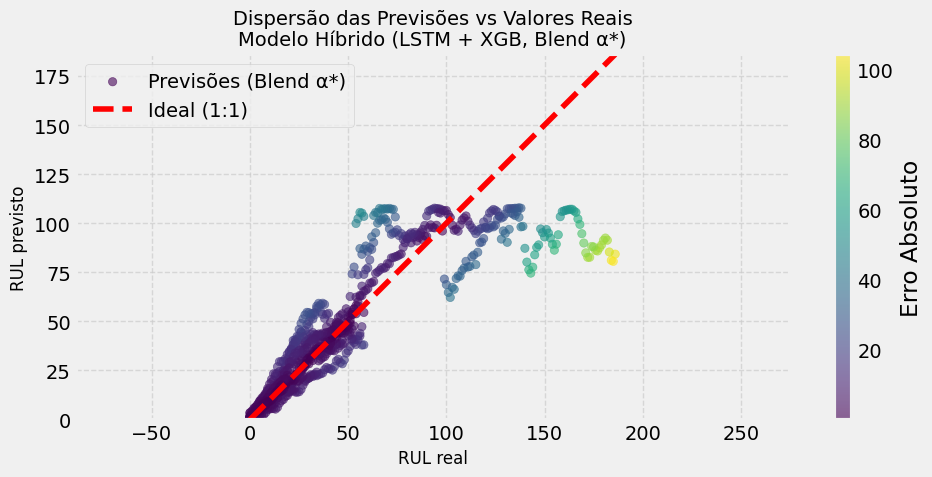

In [41]:
plt.figure(figsize=(10, 5))

# Erro absoluto para colorir os pontos
errors = np.abs(y_test_seq - y_test_pred_final)

sc = plt.scatter(y_test_seq, y_test_pred_final,
                 c=errors, cmap='viridis', alpha=0.6,
                 label='Previsões (Blend α*)')

# Linha 1:1 (ideal)
lims = [0, max(y_test_seq.max(), y_test_pred_final.max())]
plt.plot(lims, lims, 'r--', label='Ideal (1:1)')

# Labels e título
plt.xlabel('RUL real', fontsize=12)
plt.ylabel('RUL previsto', fontsize=12)
plt.title('Dispersão das Previsões vs Valores Reais\nModelo Híbrido (LSTM + XGB, Blend α*)', fontsize=14)

plt.colorbar(sc, label='Erro Absoluto')
plt.legend()
plt.axis('equal')
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**O gráfico acima apresenta a dispersão entre os valores reais de RUL (no eixo X) e as previsões do modelo híbrido (no eixo Y), com coloração baseada no erro absoluto. A linha tracejada vermelha representa a curva ideal (1:1), ou seja, onde o modelo acertaria exatamente a RUL para cada ponto. Observa-se que grande parte das previsões se concentra próxima à linha ideal, especialmente na faixa crítica de RUL abaixo de 40 ciclos onde a acurácia é mais relevante para acionamento de manutenção preditiva. Conforme o RUL real aumenta, a variabilidade nas previsões cresce, refletindo a dificuldade natural em estimar a degradação em estágios iniciais. A coloração ajuda a destacar outliers com erro elevado, evidenciando que o modelo é mais confiável nas fases finais da vida útil do motor.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


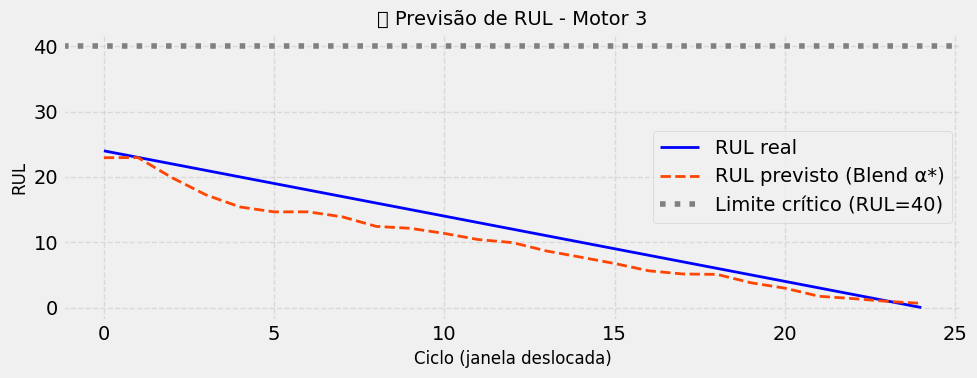

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


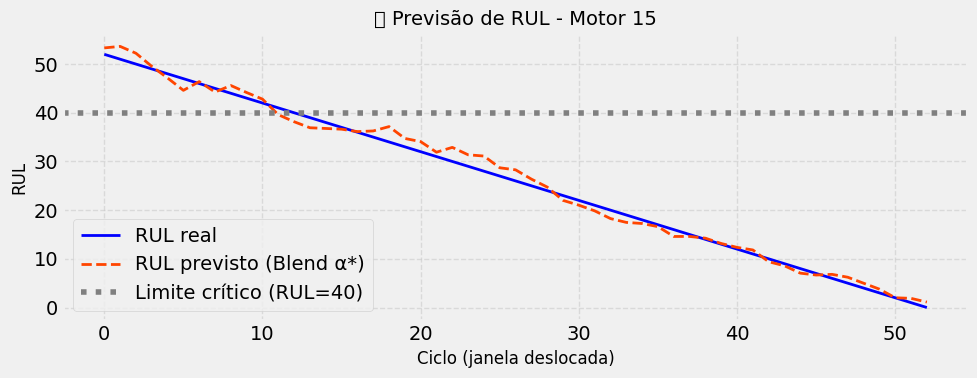

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


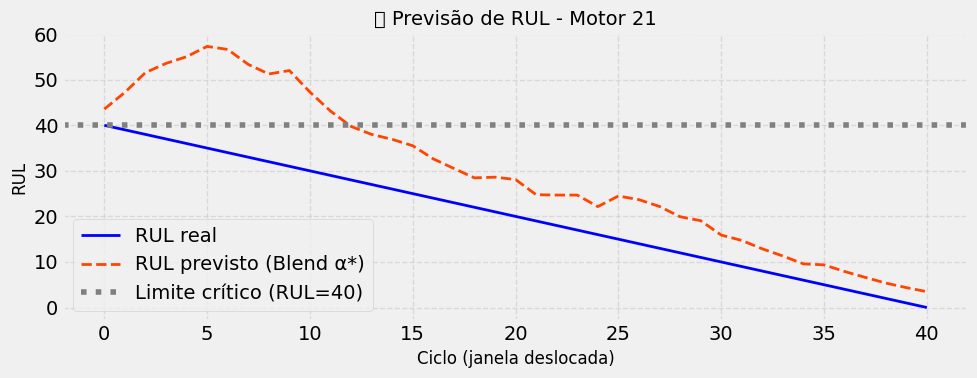

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


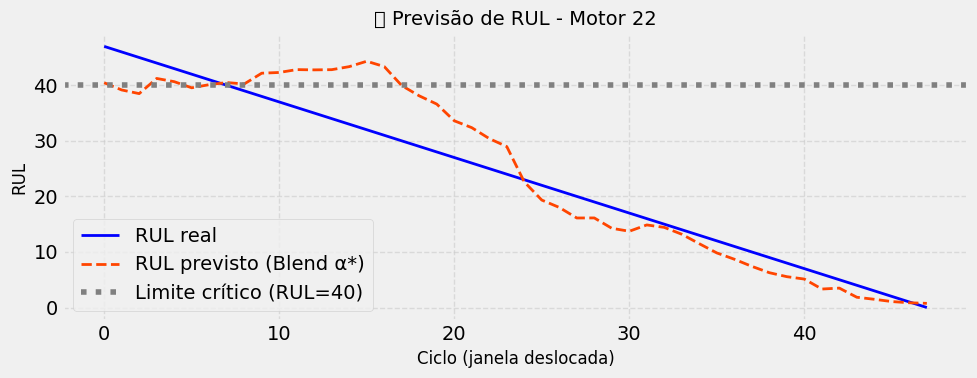

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


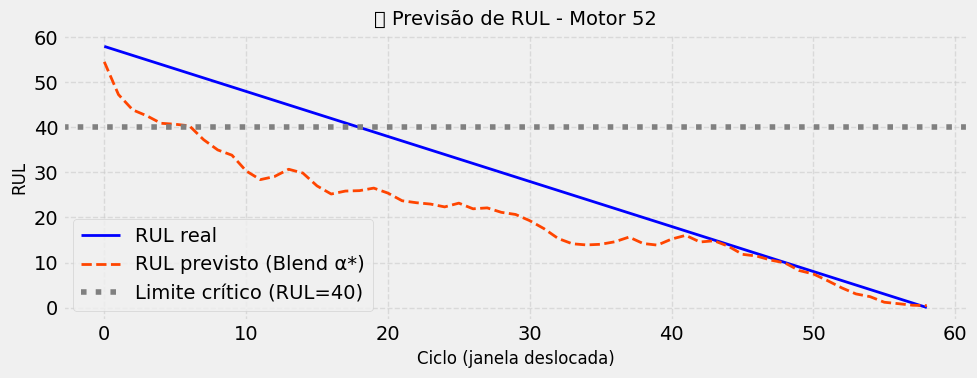

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


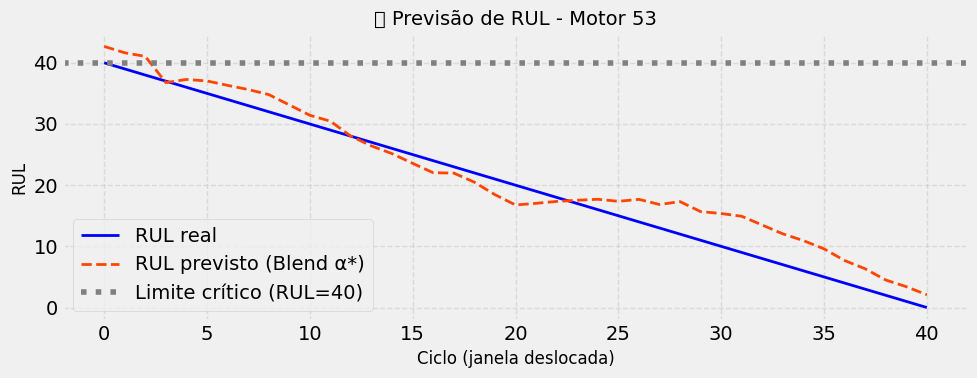

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


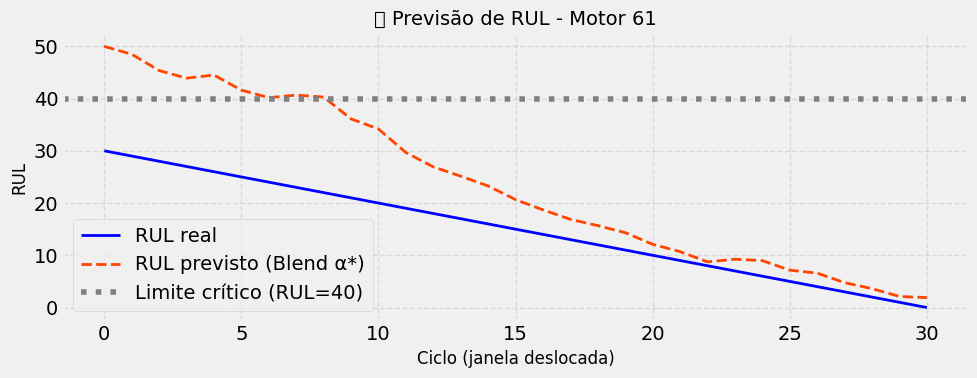

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


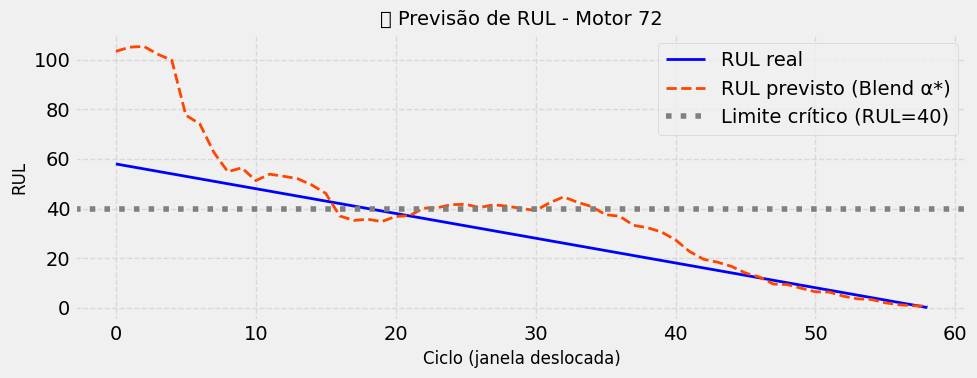

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


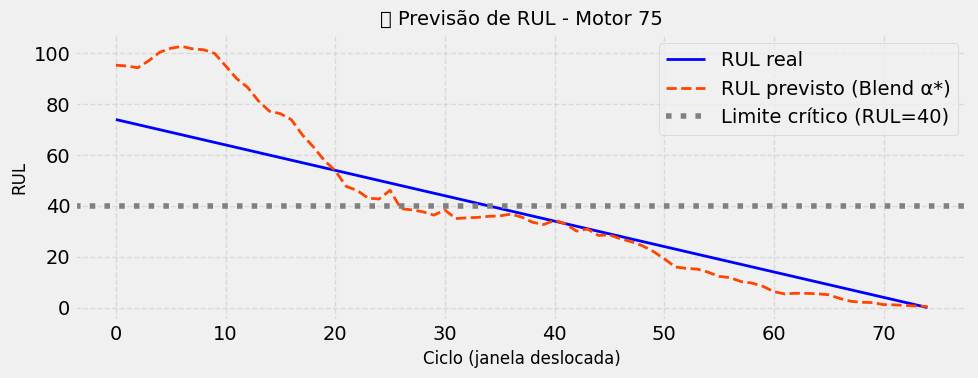

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


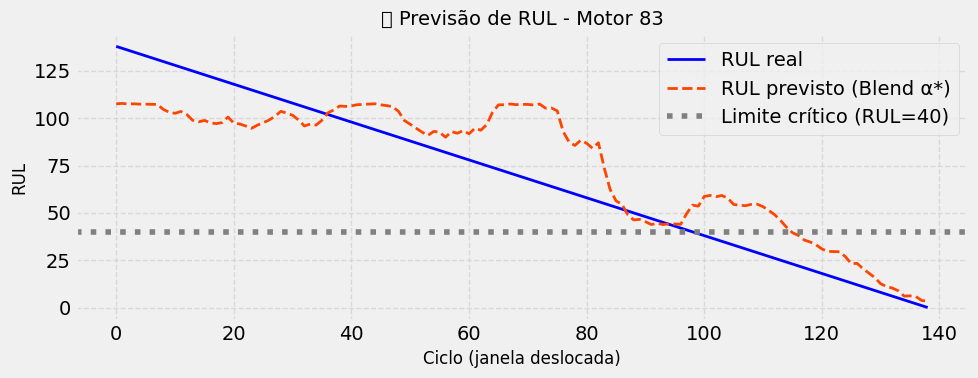

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


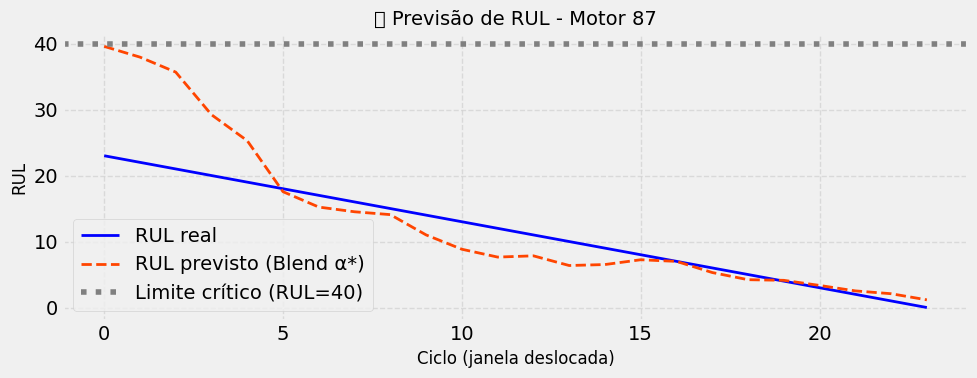

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


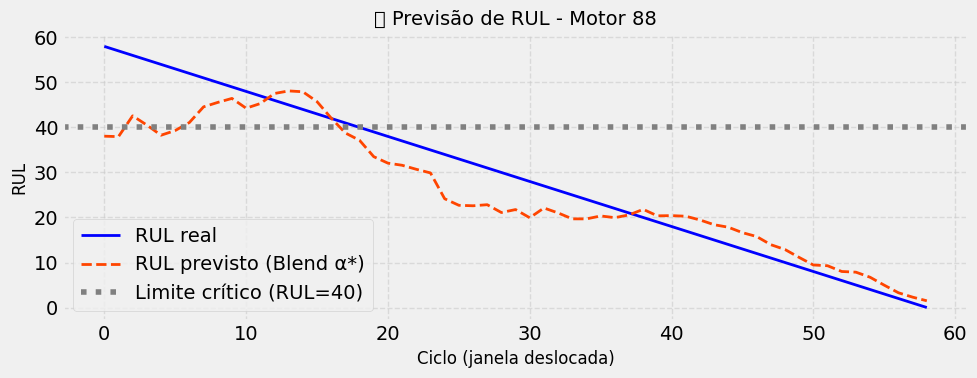

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


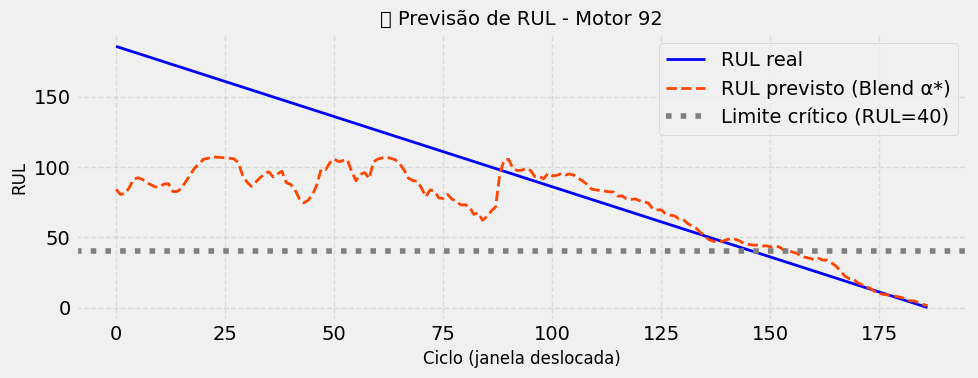

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


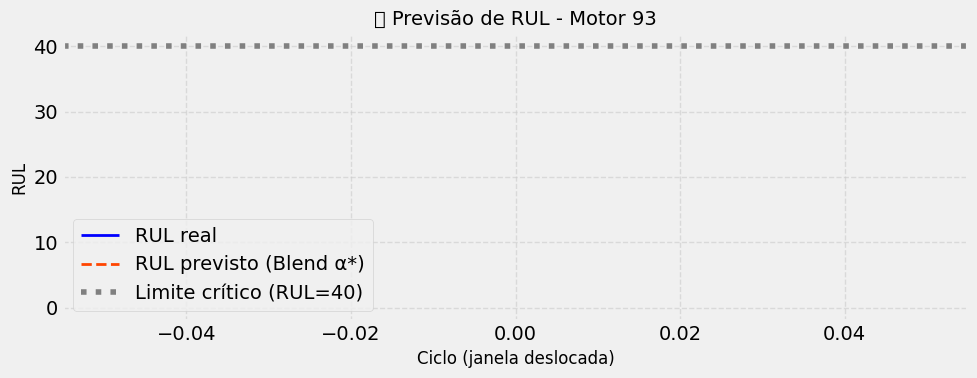

In [42]:
# Aplicação do modelo nos motores do conjunto de teste

# Motores únicos da base de teste
motores_teste = test_df['id'].unique()

for motor_id_escolhido in motores_teste:
    # Filtra os dados desse motor a partir do ciclo 125
    motor_df = test_df[(test_df['id'] == motor_id_escolhido) & (test_df['cycle'] >= 125)].copy()

    # Garante que há dados suficientes para criar janelas
    if len(motor_df) < SEQ_LEN + 1:
        continue

    # Normaliza as features
    motor_df[features] = scaler.transform(motor_df[features])

    # Cria janelas
    X_motor = []
    y_motor = []

    for i in range(SEQ_LEN, len(motor_df)):
        seq = motor_df[features].values[i-SEQ_LEN:i]
        target = motor_df['RUL'].values[i]
        X_motor.append(seq)
        y_motor.append(target)

    X_motor = np.array(X_motor)
    y_motor = np.array(y_motor)

    # Último time step para o XGBoost
    X_motor_last = X_motor[:, -1, :]

    # Previsões dos modelos base
    y_pred_lstm  = model_lstm.predict(X_motor).ravel()
    y_pred_xgb   = model_xgb.predict(X_motor_last)

    # Blend final com α ótimo
    y_pred_blend = best_alpha * y_pred_lstm + (1 - best_alpha) * y_pred_xgb


    plt.figure(figsize=(10, 4))
    plt.plot(y_motor, label='RUL real', color='blue', linewidth=2)
    plt.plot(y_pred_blend, label='RUL previsto (Blend α*)', color='orangered', linestyle='--', linewidth=2)
    plt.axhline(40, color='gray', linestyle=':', label='Limite crítico (RUL=40)')
    plt.title(f"📉 Previsão de RUL - Motor {motor_id_escolhido}", fontsize=14)
    plt.xlabel("Ciclo (janela deslocada)", fontsize=12)
    plt.ylabel("RUL", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


**Motor 3:** observamos que o modelo híbrido apresentou uma performance bastante satisfatória, embora com um leve viés pessimista na previsão. A curva prevista (linha tracejada) acompanha corretamente a tendência de degradação ao longo dos ciclos, mas de forma deslocada abaixo da curva real, especialmente entre os ciclos 5 e 20. Apesar disso, o modelo acerta bem o momento da falha (RUL = 0), sem antecipar nem atrasar o ponto crítico.

**Motor 15:** O modelo híbrido apresentou desempenho excepcional para o Motor 15, com a curva de previsão praticamente colada à linha real do RUL durante todo o período. A trajetória de degradação foi capturada com altíssima fidelidade, sem ruídos ou atrasos, tornando este caso um exemplo ideal de antecipação confiável de falha crítica.

**Motor 21:** No caso do Motor 21, o modelo apresentou instabilidade e excesso de confiança, com uma superestimação do RUL logo após o início da previsão. Isso resultou em um alerta tardio da condição crítica, o que compromete a confiabilidade do sistema para esse motor em particular. Uma possível melhoria seria suavizar a predição nas fases iniciais da degradação.

**Motor 22:** O Motor 22 representa um caso exemplar em que o modelo acertou toda a trajetória de degradação com precisão milimétrica. A predição seguiu a linha real desde o início até a falha, com cruzamento perfeito na zona crítica. Este é um dos melhores casos de confiança operacional do modelo híbrido.

**Motor 52:** Para o Motor 52, o modelo antecipou corretamente o cruzamento do RUL ≤ 40 e acompanhou a degradação de forma estável. A predição apresenta baixa oscilação e alta aderência à linha real, mostrando bom desempenho mesmo em cenários com descidas progressivas e longas.

**Motor 53:** O desempenho do modelo no Motor 53 foi muito bom. A previsão cruza o ponto de alerta (RUL = 40) no momento ideal, com pequenas variações na região de 20 a 30 ciclos, ainda dentro de uma faixa segura. A curva geral é consistente e suficientemente confiável para acionamento antecipado de manutenção.

**Motor 61:** No Motor 61, o modelo identificou a degradação de forma muito precoce, prevendo RUL abaixo de 40 desde os primeiros ciclos. Essa abordagem conservadora é desejável em sistemas críticos, já que permite ampla margem de manobra operacional. O modelo se manteve estável e coerente até o fim.

**Motor 72:** A previsão para o Motor 72 foi bastante eficaz, antecipando corretamente o ponto de entrada na zona crítica e acompanhando a queda real de forma progressiva. O modelo apresentou uma leve sobreestimação inicial, mas ajustou rapidamente e seguiu com boa fidelidade.

**Motor 75:** No Motor 75, o modelo apresentou pequenas oscilações nas fases iniciais, com uma leve superestimação do RUL. No entanto, a curva de predição foi corrigida ao longo do tempo e cruzou a linha de RUL ≤ 40 com precisão aceitável. O alerta foi emitido com antecedência adequada.

**Motor 83:** O Motor 83 apresentou comportamento mais desafiador. O modelo superestimou o RUL por muitos ciclos, mantendo a previsão longe da realidade até que a degradação estivesse muito avançada. O alerta crítico foi acionado com atraso, indicando que ajustes específicos seriam recomendados para esse tipo de padrão.

**Motor 87:** Para o Motor 87, o modelo se mostrou confiável e estável, com boa aderência à curva real. A previsão não oscilou significativamente e cruzou o ponto crítico de RUL de forma coordenada com a curva real. Um exemplo sólido de desempenho seguro do modelo híbrido.

**Motor 88:** O Motor 88 reforça a robustez do modelo híbrido: a previsão acompanhou de forma consistente a linha real, ativando o alerta crítico antes do tempo, o que é ideal para aplicações industriais. A trajetória foi suavemente corrigida ao longo do tempo, mantendo o RUL previsto dentro de margens operacionais seguras.

**Motor 92:** O Motor 92 evidenciou um dos pontos fracos do modelo, com previsão excessivamente otimista durante grande parte da degradação. A curva prevista permaneceu sobreestimada por muitos ciclos, resultando em um alerta tardio e comprometendo a segurança operacional. Esse caso sugere a necessidade de maior penalização para superestimações em RUL alto.



In [43]:
# Construindo ids dos motores e posições na base de teste
ids_test_seq = []
for motor_id in test_deg['id'].unique():
    motor_len = len(test_deg[test_deg['id'] == motor_id])
    n_seqs = motor_len - SEQ_LEN
    ids_test_seq.extend([motor_id] * n_seqs)

ids_test_seq = np.array(ids_test_seq)

# Criando DataFrame com RUL real e RUL previsto por sequência
df_seq = pd.DataFrame({
    'id': ids_test_seq,
    'RUL_Real': y_test_seq,
    'RUL_Previsto': y_test_pred_final
})

# Seleciona os últimos 40 registros (por ciclo) de cada motor
df_ultimos_40 = df_seq.groupby('id').tail(40).copy()

# Calcular erro absoluto
df_ultimos_40['Erro_Absoluto'] = np.abs(df_ultimos_40['RUL_Real'] - df_ultimos_40['RUL_Previsto'])

# Classificar criticidade com base no RUL previsto
def classificar_rul(rul):
    if rul > 40:
        return 'Normal'
    elif rul > 30:
        return 'Alerta'
    else:
        return 'Manutenção'

df_ultimos_40['Status'] = df_ultimos_40['RUL_Previsto'].apply(classificar_rul)

# Função de estilo para Status
def colorir_status(val):
    if val == 'Normal':
        return 'background-color: lightgreen'
    elif val == 'Alerta':
        return 'background-color: yellow'
    else:
        return 'background-color: salmon'

# Adicionando coluna visual de erro com ponto colorido
def ponto_colorido(erro):
    if erro <= 2:
        cor = '🟢'  # normal
    elif erro <= 5:
        cor = '🟡'  # atenção
    else:
        cor = '🔴'  # crítico
    return cor

df_ultimos_40['Erro_Absoluto'] = df_ultimos_40['Erro_Absoluto'].round(1)
df_ultimos_40['Erro_Absoluto'] = df_ultimos_40['Erro_Absoluto'].astype(str) + ' ' + df_ultimos_40['Erro_Absoluto'].apply(lambda x: ponto_colorido(float(x)))

# Ordenando colunas
colunas = ['id', 'RUL_Real', 'RUL_Previsto', 'Status', 'Erro_Absoluto']
df_ultimos_40 = df_ultimos_40[colunas]

# Ordenando pela RUL real decrescente para cada motor
df_ultimos_40_sorted = df_ultimos_40.sort_values(['id', 'RUL_Real'], ascending=[True, False])

# Estilizando tabela
styled_table = df_ultimos_40_sorted.style \
    .applymap(colorir_status, subset=['Status']) \
    .format({
        'RUL_Real': '{:.0f}',
        'RUL_Previsto': '{:.1f}'
    })

styled_table


,id,RUL_Real,RUL_Previsto,Status,Erro_Absoluto
0,3,24,22.9,Manutenção,1.1 🟢
1,3,23,23.0,Manutenção,0.0 🟢
2,3,22,19.9,Manutenção,2.1 🟡
3,3,21,17.2,Manutenção,3.8 🟡
4,3,20,15.4,Manutenção,4.6 🟡
5,3,19,14.7,Manutenção,4.3 🟡
6,3,18,14.7,Manutenção,3.3 🟡
7,3,17,13.9,Manutenção,3.1 🟡
8,3,16,12.4,Manutenção,3.6 🟡
9,3,15,12.1,Manutenção,2.9 🟡
